In [40]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import re
import os
import imageio

In [41]:
def parse_input_file(filename):
    """
    Parse the input file to extract node information and calculate congestion.

    Parameters:
    - filename: The name of the file containing the net data.
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Pattern for getting the node info
    node_pattern = re.compile(r'Node:\s*(\d+)\s+(\w+)\s+\((\d+),(\d+),(\d+)\)\s*(.*)')

    # Saves which nets use the node_id, to calculate congestion
    congestion_map = defaultdict(set)

    # Saves for each location what net_ids use it
    net_locations = defaultdict(set)

    # Save for each location which nodes are in that location
    node_locations = defaultdict(set)


    net_paths = defaultdict(list)

    for line in lines:
        line = line.strip()

        if line.startswith("Net"):
            current_net = int(line.split()[1])
        elif line.startswith("Node:"):
            # Match the node line
            match = node_pattern.match(line)
            if match:
                node_id, node_type, z, x, y, additional_info = match.groups()
                key = (int(z), int(x), int(y))

                # Ignore SINK and SOURCE nodes
                if node_type in ['SINK', 'SOURCE']:
                    continue

                # Update the maps
                congestion_map[node_id].add(current_net)
                net_locations[key].add(current_net)
                node_locations[key].add(node_id)

                # CHANX and CHANY nodes: Extract destination coordinates
                if node_type in ['CHANX', 'CHANY']:
                    dest_match = re.search(r'to\s+\((\d+),(\d+)\)', additional_info)
                    if dest_match:
                        x_dest, y_dest = dest_match.groups()
                        dest_key = (int(z), int(x_dest), int(y_dest))
                        net_locations[dest_key].add(current_net)
                        node_locations[dest_key].add(node_id)
                        net_paths[current_net].append([key, dest_key])

    return congestion_map, net_locations, node_locations, net_paths


In [42]:
def calculate_average_congestion(congestion_map, node_locations):
    """
    Calculate the average congestion for each location by averaging the congestion of nodes at that location.

    Parameters:
    - congestion_map: A dictionary where keys are node IDs and values are congestion counts.
    - node_locations: A dictionary mapping locations to node IDs at that location.

    Returns:
    - average_congestion_map: A dictionary where keys are locations and values are average congestion.
    """
    location_congestion = defaultdict(list)

    for location, node_ids in node_locations.items():
        for node_id in node_ids:
            if node_id in congestion_map:
                location_congestion[location].append(len(congestion_map[node_id]) - 1)

    average_congestion_map = {}
    for location, congestions in location_congestion.items():
        average_congestion_map[location] = np.mean(congestions)

    return average_congestion_map

In [43]:
def plot_average_congestion_heatmap(average_congestion_map):
    """
    Plot the heatmap for average congestion values at each location.

    Parameters:
    - average_congestion_map: A dictionary where keys are locations and values are average congestion values.
    """
    # Extract coordinates and average congestion values
    x_coords = [loc[1] for loc in average_congestion_map.keys()]
    y_coords = [loc[2] for loc in average_congestion_map.keys()]
    congestion_values = [value for value in average_congestion_map.values()]

    # Create a grid for the heatmap
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
    grid_z = np.zeros_like(grid_x, dtype=float)

    # Fill in the grid with average congestion values
    for (x, y), congestion in zip(zip(x_coords, y_coords), congestion_values):
        grid_z[y - y_min, x - x_min] = congestion

    # Plotting
    # Define the color scale limits
    min_congestion = 0.0
    max_congestion = np.max(grid_z) if np.max(grid_z) > 0 else 1

    plt.figure(figsize=(12, 8))
    sns.heatmap(grid_z, cmap='Reds', cbar=True, square=True,
                xticklabels=np.arange(x_min, x_max + 1),
                yticklabels=np.arange(y_min, y_max + 1),
                vmin=min_congestion, vmax = max_congestion)

    plt.title('Average Congestion Heatmap')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()




In [44]:
def get_nets_at_point(net_locations, point):
    """
    Retrieve the list of nets using a specific point from the congestion map.

    Parameters:
    - congestion_map: A dictionary with node locations and their associated data.
    - point: A tuple representing the coordinates of the point in the format (z, x, y).

    Returns:
    - A list of nets using the specified point.
    """
    return net_locations[point]


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_congestion_with_net_paths(average_congestion_map, net_paths, net_id):
    """
    Plot the heatmap for average congestion values and overlay the paths of a specified net.

    Parameters:
    - average_congestion_map: A dictionary where keys are locations and values are average congestion values.
    - net_paths: A dictionary where keys are net IDs and values are lists of lists representing paths.
    - net_id: The ID of the net to visualize.
    """
    if net_id not in net_paths:
        print(f"Net ID {net_id} not found in net_paths.")
        return

    # Extract coordinates and average congestion values
    x_coords = [loc[1] for loc in average_congestion_map.keys()]
    y_coords = [loc[2] for loc in average_congestion_map.keys()]
    congestion_values = [value for value in average_congestion_map.values()]

    # Create a grid for the heatmap
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
    grid_z = np.zeros_like(grid_x, dtype=float)

    # Fill in the grid with average congestion values
    for (x, y), congestion in zip(zip(x_coords, y_coords), congestion_values):
        grid_z[y - y_min, x - x_min] = congestion

    # Ensure all values are non-negative (if necessary)
    grid_z = np.clip(grid_z, a_min=0, a_max=None)

    # Define the color scale limits
    min_congestion = 0
    max_congestion = np.max(grid_z) if np.max(grid_z) > 0 else 1  # Avoid vmax being zero

    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot heatmap
    sns.heatmap(grid_z, cmap='Reds', cbar=True, square=True,
                xticklabels=np.arange(x_min, x_max + 1),
                yticklabels=np.arange(y_min, y_max + 1),
                vmin=min_congestion, vmax=max_congestion)  # Explicitly set vmin and vmax

    # Overlay net paths
    for path in net_paths[net_id]:
        # Draw lines for the path
        for (z1, x1, y1), (z2, x2, y2) in zip(path[:-1], path[1:]):
            plt.plot([x1 + 0.5, x2 + 0.5], [y1 + 0.5, y2 + 0.5], 'bo-', markersize=5, linewidth=2)

    plt.title(f'Congestion Heatmap with Net Paths for Net {net_id}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # plt.show()


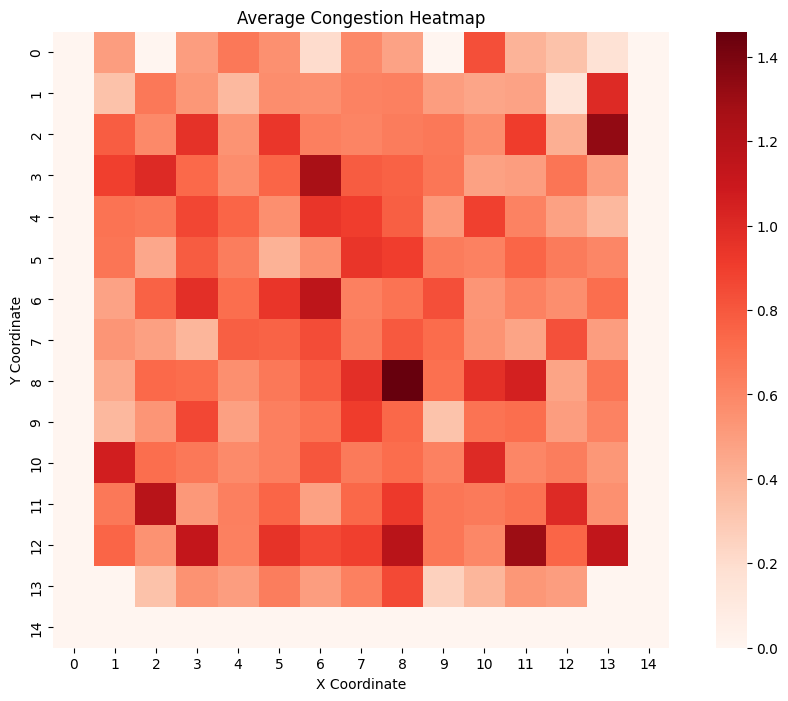

In [46]:
filename = 'Iterations/iteration_001.route'  # Replace with the actual filename
congestion_map, net_locations, node_locations, net_paths  = parse_input_file(filename)
avg_cong_map = calculate_average_congestion(congestion_map, node_locations)
plot_average_congestion_heatmap(avg_cong_map)


In [ ]:
congestion_map

defaultdict(set,
            {'7373': {0},
             '12808': {0},
             '15770': {0, 94, 272},
             '7546': {0},
             '7756': {1},
             '15805': {1},
             '7562': {1, 3},
             '6787': {2, 19, 242},
             '13494': {2, 19},
             '7553': {2, 12, 19, 25},
             '8224': {3},
             '15772': {3},
             '8332': {4},
             '15792': {4, 85, 114},
             '7554': {4},
             '9078': {5},
             '16140': {5},
             '9954': {5},
             '9212': {5},
             '9081': {5},
             '13143': {5, 63, 243, 412, 434, 435},
             '8307': {5, 85, 91, 93, 95, 99},
             '13099': {5, 243, 457},
             '5841': {5},
             '15094': {5},
             '5162': {5},
             '5208': {5},
             '5059': {5, 243, 326},
             '9079': {5},
             '12967': {5},
             '15606': {5, 85, 95, 238, 581, 582},
             '7602': {5, 22, 85,

In [ ]:
net_paths

defaultdict(list,
            {0: [[(0, 9, 6), (0, 12, 6)], [(0, 9, 7), (0, 9, 10)]],
             1: [[(0, 9, 10), (0, 9, 13)]],
             2: [[(0, 8, 10), (0, 11, 10)]],
             3: [[(0, 9, 7), (0, 9, 10)]],
             4: [[(0, 9, 9), (0, 9, 12)]],
             5: [[(0, 11, 8), (0, 11, 11)],
              [(0, 11, 8), (0, 11, 11)],
              [(0, 8, 8), (0, 11, 8)],
              [(0, 8, 8), (0, 11, 8)],
              [(0, 4, 8), (0, 7, 8)],
              [(0, 4, 8), (0, 7, 8)],
              [(0, 5, 9), (0, 5, 12)],
              [(0, 5, 9), (0, 5, 12)],
              [(0, 4, 8), (0, 7, 8)],
              [(0, 8, 7), (0, 11, 7)],
              [(0, 8, 8), (0, 8, 11)],
              [(0, 8, 8), (0, 8, 11)],
              [(0, 8, 7), (0, 11, 7)],
              [(0, 8, 4), (0, 8, 7)],
              [(0, 11, 7), (0, 13, 7)],
              [(0, 11, 4), (0, 11, 7)]],
             6: [[(0, 8, 9), (0, 8, 12)],
              [(0, 8, 6), (0, 8, 9)],
              [(0, 8, 2), (0,

In [ ]:
net_locations

defaultdict(set,
            {(0, 9, 6): {0,
              5,
              27,
              29,
              49,
              53,
              59,
              67,
              76,
              80,
              82,
              85,
              88,
              90,
              95,
              97,
              101,
              113,
              126,
              131,
              132,
              133,
              134,
              135,
              136,
              137,
              138,
              139,
              140,
              141,
              142,
              143,
              144,
              149,
              152,
              176,
              184,
              235,
              305,
              342,
              399,
              414,
              442,
              455,
              468,
              563,
              595,
              634,
              705,
              706},
             (0, 12, 6): {0,
          

In [ ]:
node_locations

defaultdict(set,
            {(0, 9, 6): {'12768',
              '12771',
              '12774',
              '12775',
              '12801',
              '12802',
              '12803',
              '12805',
              '12808',
              '15729',
              '15730',
              '15732',
              '15761',
              '15762',
              '15764',
              '15765',
              '15766',
              '15767',
              '7329',
              '7331',
              '7332',
              '7334',
              '7335',
              '7336',
              '7340',
              '7342',
              '7346',
              '7348',
              '7349',
              '7373'},
             (0, 12, 6): {'12801',
              '12802',
              '12803',
              '12805',
              '12808',
              '12834',
              '16257',
              '16259',
              '16262',
              '16287',
              '16288',
              '16296',
     

In [ ]:
avg_cong_map

{(0, 9, 6): 0.8333333333333334,
 (0, 12, 6): 0.5652173913043478,
 (0, 9, 7): 0.7222222222222222,
 (0, 9, 10): 0.6216216216216216,
 (0, 9, 13): 0.25925925925925924,
 (0, 8, 10): 0.7142857142857143,
 (0, 11, 10): 0.6,
 (0, 10, 7): 0.5428571428571428,
 (0, 10, 9): 0.6875,
 (0, 9, 9): 0.32558139534883723,
 (0, 9, 12): 0.6774193548387096,
 (0, 11, 8): 1.054054054054054,
 (0, 11, 11): 0.6923076923076923,
 (0, 12, 10): 0.64,
 (0, 8, 8): 1.4594594594594594,
 (0, 4, 8): 0.5625,
 (0, 7, 8): 0.9705882352941176,
 (0, 5, 9): 0.6333333333333333,
 (0, 5, 12): 0.9523809523809523,
 (0, 6, 10): 0.8055555555555556,
 (0, 6, 11): 0.4838709677419355,
 (0, 6, 8): 0.7777777777777778,
 (0, 8, 7): 0.7941176470588235,
 (0, 11, 7): 0.46875,
 (0, 8, 11): 0.92,
 (0, 9, 11): 0.6774193548387096,
 (0, 8, 4): 0.7714285714285715,
 (0, 13, 7): 0.5,
 (0, 11, 4): 0.6176470588235294,
 (0, 8, 9): 0.7368421052631579,
 (0, 8, 12): 1.1785714285714286,
 (0, 8, 6): 0.6842105263157895,
 (0, 8, 2): 0.6451612903225806,
 (0, 8, 5): 0

In [ ]:
get_nets_at_point(net_locations, (0, 8, 8))

{5,
 15,
 16,
 39,
 56,
 59,
 63,
 65,
 66,
 67,
 70,
 74,
 75,
 76,
 81,
 85,
 90,
 91,
 92,
 93,
 95,
 99,
 101,
 111,
 112,
 114,
 118,
 119,
 122,
 128,
 142,
 143,
 156,
 157,
 207,
 208,
 238,
 243,
 270,
 271,
 275,
 276,
 288,
 290,
 317,
 318,
 393,
 412,
 434,
 435,
 458,
 459,
 581,
 582,
 617}

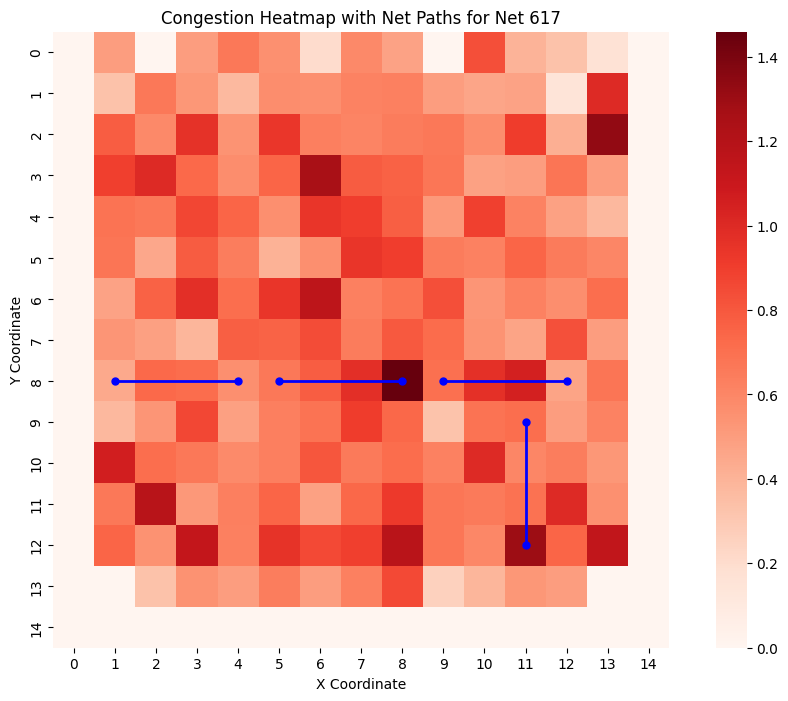

In [16]:
plot_congestion_with_net_paths(avg_cong_map, net_paths, 617)

In [56]:
def create_gif_from_iterations(folder_path, net_id, output_gif):
    # Define the pattern for matching iteration files (e.g., iteration_001.route to iteration_039.route)
    file_pattern = re.compile(r'iteration_(\d{3})\.route')

    # Get the list of iteration files, sorted by iteration number
    iteration_files = sorted(
        [f for f in os.listdir(folder_path)
         if os.path.isfile(os.path.join(folder_path, f)) and file_pattern.match(f)]
    )

    # Store images for GIF creation
    images = []

    # Loop through each iteration file
    for iteration, file in enumerate(iteration_files, start=1):
        file_path = os.path.join(folder_path, file)

        # Parse the file to get congestion_map and net_paths
        congestion_map, net_locations, node_locations, net_paths = parse_input_file(file_path)

        # Calculate the average congestion for each location
        avg_cong_map = calculate_average_congestion(congestion_map, node_locations)

        # Create the plot
        plt.figure(figsize=(12, 8))
        plot_congestion_with_net_paths(avg_cong_map, net_paths, net_id)
        plt.title(f"Net {net_id} Visualization - {file_path}")

        # Save the plot as an image
        image_filename = f"{file_path}.png"
        plt.savefig(image_filename)
        images.append(image_filename)
        plt.close()


    # Create GIF
    with imageio.get_writer(output_gif, mode='I', duration=0.5) as writer:
        for image_filename in images:
            image = imageio.imread(image_filename)
            writer.append_data(image)
            os.remove(image_filename)  # Remove the image file after adding it to the GIF

In [62]:
create_gif_from_iterations("Iterations/", net_id=6, output_gif="output_test.gif")

<ipython-input-61-bda5e4f9e2b1>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))
<ipython-input-56-a8d29c665ede>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))
<ipython-input-56-a8d29c665ede>:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imag

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>